In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 12 14:07:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf

import os
import numpy as np
import shutil
import keras

from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix, plot_confusion_matrix

tf.random.set_seed(247)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from zipfile import ZipFile

filename = '/content/drive/My Drive/colon_aug.zip'
with ZipFile(filename, 'r') as zip:
    zip.extractall()
    print('DONE')

DONE


In [6]:
base_dir = '/content/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_aca = os.path.join(train_dir, 'aca')
train_n = os.path.join(train_dir, 'n')
test_aca = os.path.join(test_dir, 'aca')
test_n = os.path.join(test_dir, 'n')

print('total training aca images:', len(os.listdir(train_aca)))
print('total training n images:', len(os.listdir(train_n)))
print('total testing aca images:', len(os.listdir(test_aca)))
print('total testing n images:', len(os.listdir(test_n)))

total training aca images: 8000
total training n images: 8000
total testing aca images: 1000
total testing n images: 1000


In [7]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)
train_dataset= datagen.flow_from_directory(train_dir, 
                                         target_size= (224,224),
                                         class_mode= 'binary',
                                         batch_size=32,
                                         shuffle=True
                                        )
test_dataset= datagen.flow_from_directory(test_dir, 
                                         target_size= (224, 224),
                                         class_mode= 'binary',
                                         batch_size=32,
                                         shuffle=False
                                        )

Found 16000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
model_d= tf.keras.applications.densenet.DenseNet121()

x= model_d.layers[-3].output
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

predictions= Dense(1, activation = 'sigmoid')(x)
model= Model(inputs= model_d.input, outputs= predictions)

for layer in model.layers[:-9]:
  layer.trainable= False

33202176/33188688 [==============================] - 0s 0us/step


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [10]:
model.compile(optimizer= SGD(learning_rate= 0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint=  ModelCheckpoint(filepath = 'd121model_sgd.hdf5',monitor='accuracy',save_best_only=True,save_weights_only=True)
Earlystop = EarlyStopping(monitor='loss', mode='min',patience=10, min_delta=0.001)
history= model.fit(train_dataset, 
                   steps_per_epoch= 16000/32,
                   verbose=1, 
                   epochs = 20, 
                   batch_size = 32,
                   callbacks=[checkpoint,Earlystop]
                   )

Epoch 1/20
500/500 [==============================] - 167s 293ms/step - loss: 0.8005 - accuracy: 0.6246
Epoch 2/20
500/500 [==============================] - 143s 285ms/step - loss: 0.4744 - accuracy: 0.7799
Epoch 3/20
500/500 [==============================] - 141s 283ms/step - loss: 0.3571 - accuracy: 0.8414
Epoch 4/20
500/500 [==============================] - 141s 282ms/step - loss: 0.2923 - accuracy: 0.8777
Epoch 5/20
500/500 [==============================] - 140s 280ms/step - loss: 0.2598 - accuracy: 0.8928
Epoch 6/20
500/500 [==============================] - 142s 284ms/step - loss: 0.2356 - accuracy: 0.9027
Epoch 7/20
500/500 [==============================] - 142s 284ms/step - loss: 0.2098 - accuracy: 0.9153
Epoch 8/20
500/500 [==============================] - 141s 282ms/step - loss: 0.1959 - accuracy: 0.9236
Epoch 9/20
500/500 [==============================] - 142s 284ms/step - loss: 0.1818 - accuracy: 0.9268
Epoch 10/20
500/500 [==============================] - 142s 283m

In [11]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'd121history_sgd.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
from tensorflow.keras import models
model.load_weights("d121model-nonaug.hdf5")

In [ ]:
predictions = model.predict(test_dataset, steps=2000/32, verbose=0)

In [ ]:
#geting predictions on test dataset
#y_pred = np.argmax(predictions, axis=1)
y_pred = [1 * (x[0]>=0.5) for x in predictions]
targetnames = ['aca', 'n']
#getting the true labels per image 
y_true = test_dataset.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)
# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

         aca       0.99      0.98      0.99      1000
           n       0.98      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



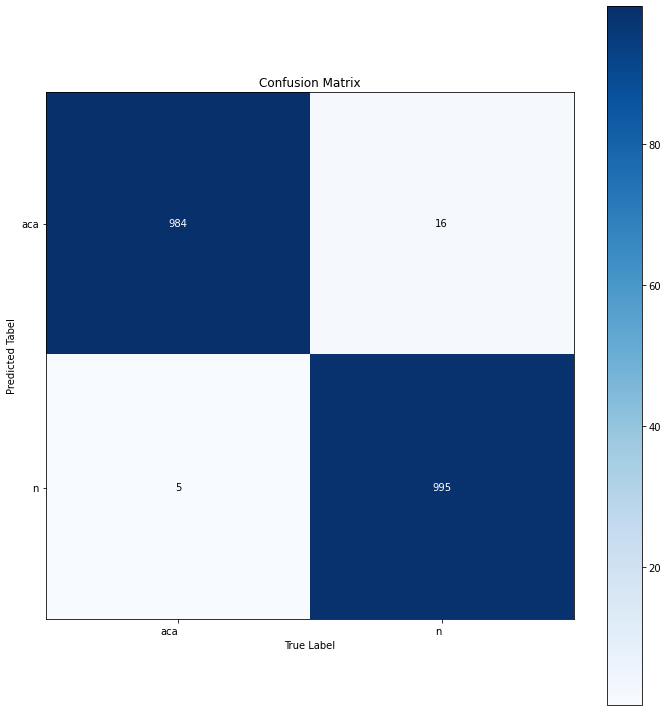

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

categories = ['aca', 'n']


def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    cm2 = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    cm2 = cm2 * 100
    # print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm2, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm2.shape[1]),
           yticks=np.arange(cm2.shape[0]),
           xticklabels=categories, yticklabels=categories,
           title=title,
           ylabel='Predicted Tabel',
           xlabel='True Label')
    plt.setp(ax.get_xticklabels(), rotation=0, ha='right', rotation_mode='anchor')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            z = cm[i, j]
            z = np.around(z)

            ax.text(j, i, format(z), ha='center', va='center', color='white' if i == j else 'black')
    fig.tight_layout()
    return ax

plot_confusion_matrix(y_true, y_pred, targetnames, title='Confusion Matrix')